## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
#%%bash
#ls

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD, RMSprop

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [4]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
#real_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/DAPI_ONLY_v3/"
#mMNIST_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_MNIST/"   
real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"
#mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
#mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"
#fashion_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_FashionMNIST/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v4/"
#real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"

train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_train_large_hard",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_test_large_hard",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_with_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_with_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

Dataset lenght: 1688
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


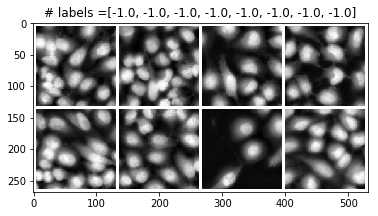

In [5]:
check_datasets(train_dataset)

Dataset lenght: 296
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


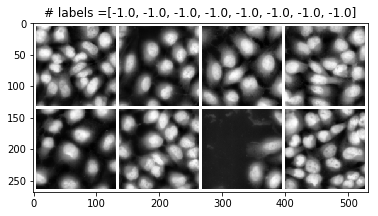

In [6]:
check_datasets(test_dataset)

tensor(-1., device='cuda:0')


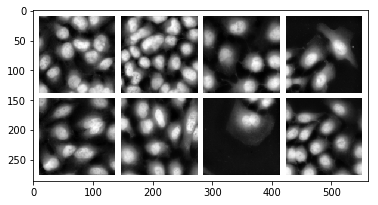

In [7]:
imgs_in, labels = train_dataset.load(8)
print(labels[0])
show_batch(imgs_in)

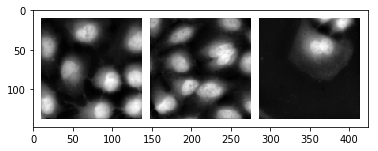

In [8]:
show_batch(imgs_in[2:-1:2])

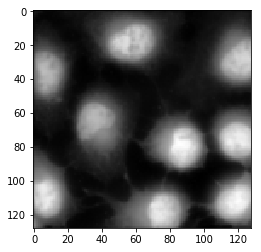

In [9]:
show_batch(imgs_in[2:3])

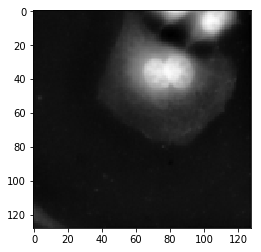

In [10]:
show_batch(imgs_in[-2:-1])

Text(0.5, 0, 'pixel intensity')

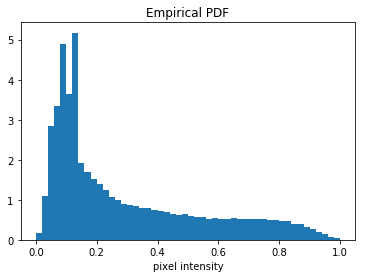

In [11]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=50, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

Text(0.5, 0, 'Average intensity in box of size 15')

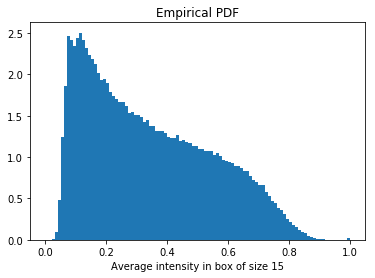

In [12]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

Text(0.5, 0, 'Average intensity in box of size 35')

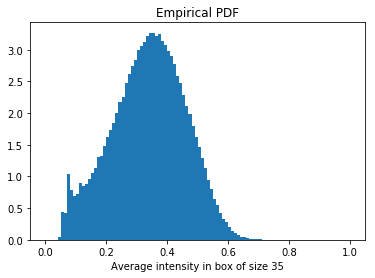

In [13]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [14]:
write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/buckets/VAE-ARCHIVE/'
#write_dir  = '/Users/ldalessi/DAPI_unsupervised/ARCHIVE/'


descriptor        = "DAPI_branch11_v02"
#descriptor        = "MNIST_v001"
#descriptor        = "FASHION_unit_cauchy_t4_v3"
#descriptor        = "MNIST_unit_cauchy_t4_v4"
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 0
is_restart = False
is_pretrained = True

if(is_restart):

    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    hyper_params.check_consistency()
    print(hyper_params)
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

else:    
    
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        
        "fg_mu_cauchy" : [],
        "bg_mu_cauchy" : [],
        "bg_mu_normal" : [],
        
        "fg_sigma_cauchy" : [],
        "bg_sigma_cauchy" : [],
        "bg_sigma_normal" : []
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    if(is_pretrained):
        vae.load_everything("/home/jupyter/REPOS/spacetx-research/ARCHIVE/GREAT_RESULT/","DAPI")
    
save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'REGULARIZATION.lambda_overlap': 0.0, 'UNET.N_prediction_maps': 1, 'SD.dim_h2': -1, 'UNET.N_max_pool': 4, 'REGULARIZATION.LOSS_ZWHAT': 10.0, 'use_cuda': True, 'ZMASK.dim': 50, 'SD.dim_h1': -1, 'REGULARIZATION.volume_mask_max': 500.0, 'REGULARIZATION.lambda_mask_volume_fraction': 1.0, 'PRIOR.n_objects_max': 30, 'REGULARIZATION.lambda_tot_var_mask': 0.0, 'REGULARIZATION.LOSS_ZMASK': 0.0, 'NMS.overlap_threshold': 0.2, 'REGULARIZATION.randomize_nms_factor': 0.2, 'PRIOR.size_object_min': 10, 'PRIOR.width_zwhat': 0.1, 'SD.width': 28, 'REGULARIZATION.volume_mask_min': 0.0, 'PRIOR.width_zmask': 0.1, 'REGULARIZATION.volume_mask_expected': 300.0, 'ZWHAT.dim': 50, 'PRIOR.size_object_max': 40, 'IMG.ch_in_description': ['DAPI'], 'IMG.size_raw_image': 80, 'REGULARIZATION.lambda_mask_volume_absolute': 0.0, 'REGULARIZATION.p_corr_factor': 0.0, 'NMS.p_threshold': 0.0, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'PRIOR.size_object_expected': 20, 'REGULARIZATION.lambda_small_box_size': 0.0,

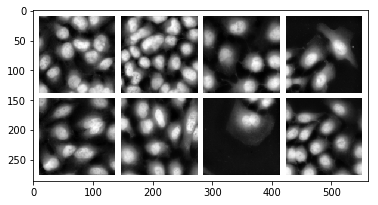

In [15]:
show_batch(imgs_in)

At layer l=  0  we have w_h_j_rf_wloc_hloc=  0 (128, 128, 1, 1, 0.5, 0.5)
At layer l=  1  we have w_h_j_rf_wloc_hloc=  1 (128, 128, 1.0, 5, 0.5, 0.5)
At layer l=  2  we have w_h_j_rf_wloc_hloc=  2 (64, 64, 2.0, 6, 1.0, 1.0)
At layer l=  3  we have w_h_j_rf_wloc_hloc=  3 (64, 64, 2.0, 14, 1.0, 1.0)
At layer l=  4  we have w_h_j_rf_wloc_hloc=  4 (32, 32, 4.0, 16, 2.0, 2.0)
At layer l=  5  we have w_h_j_rf_wloc_hloc=  5 (32, 32, 4.0, 32, 2.0, 2.0)
At layer l=  6  we have w_h_j_rf_wloc_hloc=  6 (16, 16, 8.0, 36, 4.0, 4.0)
At layer l=  7  we have w_h_j_rf_wloc_hloc=  7 (16, 16, 8.0, 68, 4.0, 4.0)
At layer l=  8  we have w_h_j_rf_wloc_hloc=  8 (8, 8, 16.0, 76, 8.0, 8.0)
At layer l=  9  we have w_h_j_rf_wloc_hloc=  9 (8, 8, 16.0, 140, 8.0, 8.0)
At layer l=  10  we have w_h_j_rf_wloc_hloc=  10 (16, 16, 8.0, 156, 4.0, 4.0)
At layer l=  11  we have w_h_j_rf_wloc_hloc=  11 (16, 16, 8.0, 188, 4.0, 4.0)
At layer l=  12  we have w_h_j_rf_wloc_hloc=  12 (32, 32, 4.0, 196, 2.0, 2.0)
At layer l=  13  w

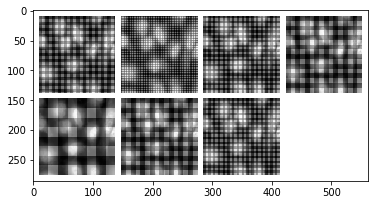

In [16]:
vae.inference.unet.describe_receptive_field(imgs_in)
img_with_grid = vae.inference.unet.show_grid(imgs_in)
print(img_with_grid.shape)
show_batch(img_with_grid[5])

In [17]:
#putative_imgs,putative_masks,background,c = vae.model()
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)
#print("max(putative_imgs)",torch.max(putative_imgs))

In [18]:
#show_batch(background)

In [19]:
#show_batch(putative_imgs[0])

In [20]:
#show_batch(putative_masks[0])
#print(torch.min(putative_masks),torch.max(putative_masks))

In [21]:
#imgs_prior = vae.generate_synthetic_data(N=2)
#show_batch(imgs_prior[:8,:1,:,:])
#print("imgs_prior.shape",imgs_prior.shape)
#print("type(imgs_prior)",type(imgs_prior))
#print("imgs_prior.device",imgs_prior.device)
#print("torch.max(imgs_prior)",torch.max(imgs_prior))
#print("torch.min(imgs_prior)",torch.min(imgs_prior))

In [22]:
#putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
##putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)
#
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)

In [23]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)
#
#print("rec_img.shape",rec_img.shape)
#print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("logp.logp_off.shape",logp.logp_off.shape)
#print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
#print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
#print("reg.small_box_size.shape",reg.small_box_size.shape)
#print("reg.big_mask_volume.shape",reg.big_mask_volume.shape)
#print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print("reg.overlap_mask.shape",reg.overlap_mask.shape)
#show_batch(rec_img[:8,:,:,:])

### Debug model and guide

In [24]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [25]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# batch size
batch_size = 50
time_scale_decay_prob = 40

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3, "betas":(0.9, 0.999)})
#optimizer = RMSprop({"lr": 1.0e-4})

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))

# Actual train loop

In [26]:
# training loop
#epoch_restart = 45
#for delta_epoch in range(1,-1):

for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
   
    vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
    vae.randomize_nms_factor = 0.1
    vae.inference.nms.overlap_threshold=0.2
    vae.inference.nms.n_objects_max=30 
    vae.n_objects_max=30
    vae.train()   
    
    
    print("epoch,vae.p_corr_factor,vae.randomize_nms_factor",epoch,vae.p_corr_factor,vae.randomize_nms_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu_cauchy"].append(pyro.param("fg_mu_cauchy").item())
        history_dict["bg_mu_cauchy"].append(pyro.param("bg_mu_cauchy").item())
        history_dict["bg_mu_normal"].append(pyro.param("bg_mu_normal").item())
        
        history_dict["fg_sigma_cauchy"].append(pyro.param("fg_sigma_cauchy").item())
        history_dict["bg_sigma_cauchy"].append(pyro.param("bg_sigma_cauchy").item())
        history_dict["bg_sigma_normal"].append(pyro.param("bg_sigma_normal").item())      
        
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):      
        vae.p_corr_factor = 0.0
        vae.randomize_nms_factor = 0.0
        vae.inference.nms.overlap_threshold=0.2
        vae.inference.nms.n_objects_max=30 
        vae.n_objects_max=30
        vae.eval()
            
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

epoch,vae.p_corr_factor,vae.randomize_nms_factor 0 0.5 0.1
i=   0 train_loss=-4105064.75000
i=   1 train_loss=-3753976.25000
i=   2 train_loss=-3475216.75000
i=   3 train_loss=-4025525.75000
i=   4 train_loss=-3923667.25000
i=   5 train_loss=-3425461.75000
i=   6 train_loss=-3584493.50000
i=   7 train_loss=-4395039.50000
i=   8 train_loss=-4340482.50000
i=   9 train_loss=-4324102.50000
i=  10 train_loss=-4229252.00000
i=  11 train_loss=-4064368.00000
i=  12 train_loss=-4126900.00000
i=  13 train_loss=-3768644.25000
i=  14 train_loss=-3553562.00000
i=  15 train_loss=-4017726.75000
i=  16 train_loss=-3909514.00000
i=  17 train_loss=-3892898.50000
i=  18 train_loss=-3728652.00000
i=  19 train_loss=-4101485.50000
i=  20 train_loss=-4196780.00000
i=  21 train_loss=-3755985.75000
i=  22 train_loss=-4671309.50000
i=  23 train_loss=-4051676.50000
i=  24 train_loss=-3779937.25000
i=  25 train_loss=-3574892.00000
i=  26 train_loss=-3651463.00000
i=  27 train_loss=-3914722.50000
i=  28 train_loss

KeyboardInterrupt: 

# Check the results

In [27]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])

print(history_dict["fg_mu_cauchy"][-5:])
print(history_dict["bg_mu_cauchy"][-5:])
print(history_dict["bg_mu_normal"][-5:])

print(history_dict["fg_sigma_cauchy"][-5:])
print(history_dict["bg_sigma_cauchy"][-5:])
print(history_dict["bg_sigma_normal"][-5:])

[-107030.66515151515, -108615.76484848485, -110413.04454545454, -111670.8009090909, -113146.50242424243]
[-135196.73, -137209.666, -138118.342, -140623.574, -142329.524]
[0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421]
[0.06534682214260101, 0.06462161988019943, 0.06385138630867004, 0.06323955953121185, 0.06270807981491089]
[0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612]
[0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224]
[0.16522116959095, 0.16296476125717163, 0.16061124205589294, 0.15816597640514374, 0.15581195056438446]
[0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224]


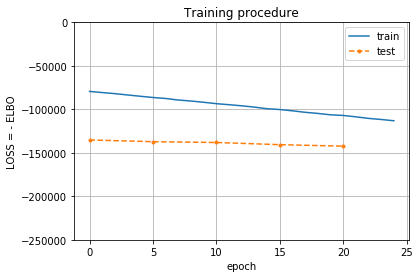

In [28]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign =1.0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
#plt.ylim(bottom=-250000, top=200000)
plt.ylim(bottom=-250000, top=0)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

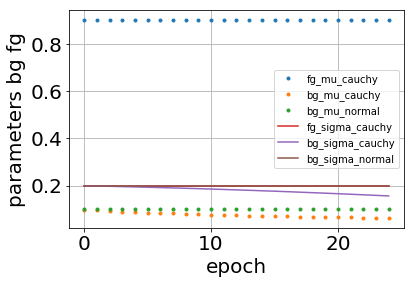

In [29]:
# Create a plot with learned parameters
fontsize=20
labelsize=20
plt.xlabel('epoch',fontsize=fontsize)
plt.ylabel('parameters bg fg',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.plot(history_dict["fg_mu_cauchy"],'.')
plt.plot(history_dict["bg_mu_cauchy"],'.')
plt.plot(history_dict["bg_mu_normal"],'.')

plt.plot(history_dict["fg_sigma_cauchy"],'-')
plt.plot(history_dict["bg_sigma_cauchy"],'-')
plt.plot(history_dict["bg_sigma_normal"],'-')

plt.legend(['fg_mu_cauchy','bg_mu_cauchy','bg_mu_normal',
            'fg_sigma_cauchy','bg_sigma_cauchy','bg_sigma_normal'])
plt.grid(True)
              
mp.savefig(write_dir+name_vae+'_hystory.png')

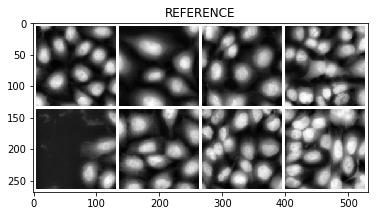

In [30]:
from matplotlib import pyplot as mp

#reference_dir = '/Users/ldalessi/DAPI_unsupervised/REFERENCES/'
#reference_dir = '/home/ldalessi/DATA/REFERENCE/'
reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
#name='reference_mMNIST_v2'
#name='reference_disks_v3'
name='reference_dapi'
#name='reference_fashion'

# create image if necessary
#reference_imgs, labels=test_dataset.load(8)
#save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

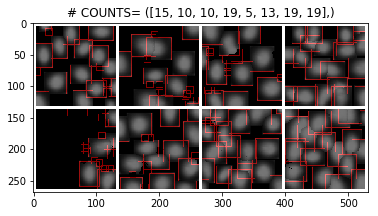

In [31]:
vae.p_corr_factor = 0.0
vae.randomize_nms_factor = 0.0
vae.inference.nms.overlap_threshold=0.4
vae.inference.nms.n_objects_max=20 
vae.n_objects_max=20

rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [32]:
chosen=7
print(z_where.prob[chosen].view(-1))

tensor([0.9959, 0.9951, 0.9949, 0.9945, 0.9938, 0.9934, 0.9931, 0.9900, 0.9895,
        0.9882, 0.9875, 0.9875, 0.9867, 0.9857, 0.9791, 0.9769, 0.9640, 0.9559,
        0.8318, 0.4739], device='cuda:0')


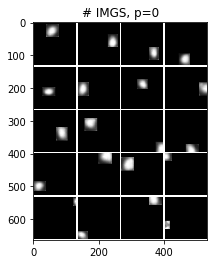

In [33]:
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
prob_title = 0
b=show_batch(putative_imgs[chosen],nrow=4,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0822, 0.4799,
        0.9491, 0.9994, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9417, 0.4885, 

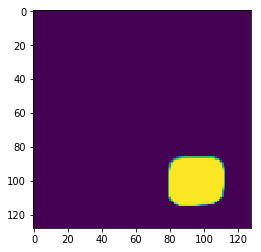

In [34]:
plt.imshow(putative_masks[0,0,0].cpu())
print(putative_masks[0,0,0,90])

DAPI_branch11_v02_vae


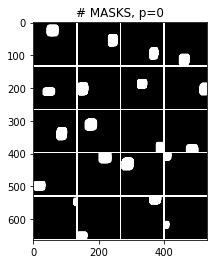

In [35]:
b=show_batch(putative_masks[chosen],nrow=4,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

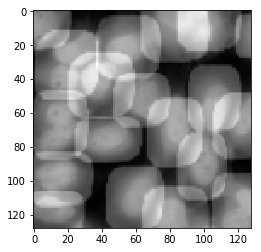

In [36]:
active = (z_where.prob[chosen] > 0.5)[...,None,None].float()
show_batch(torch.sum(active*putative_masks[chosen],dim=0,keepdim=True)+2*reference_imgs[chosen])
mp.savefig(write_dir+name_vae+'_debug0_imgs.png')

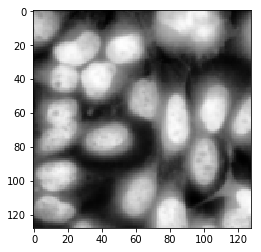

In [37]:
show_batch(reference_imgs[chosen:chosen+1])

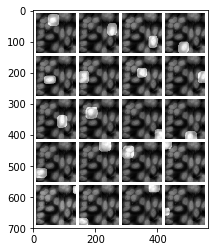

In [38]:
show_batch(putative_masks[chosen]+reference_imgs[chosen,0])
mp.savefig(write_dir+name_vae+'_debug1_imgs.png')

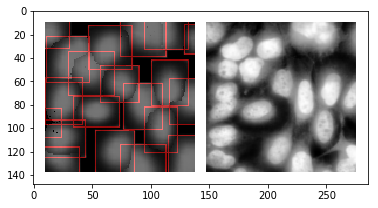

In [39]:
tmp1 = rec_img[chosen].unsqueeze(0)
tmp2 = reference_imgs[chosen].unsqueeze(0).expand(-1,3,-1,-1)
tmp = torch.cat((tmp1,tmp2),dim=0)
show_batch(tmp)
mp.savefig(write_dir+name_vae+'_debug2_imgs.png')

In [40]:
print("reg_small_box ----->",vae.lambda_small_box_size*reg.small_box_size[chosen,:16].detach().cpu())
print("reg_mask_fraction ->",vae.lambda_mask_volume_fraction*reg.mask_volume_fraction[chosen,:16].detach().cpu())
print("reg_mask_absolute ->",vae.lambda_mask_volume_absolute*reg.mask_volume_absolute[chosen,:16].detach().cpu())
print("reg_tot_var ------->",vae.lambda_tot_var_mask*reg.tot_var_mask[chosen,:16].detach().cpu())
print("reg_mask_overlap -->",vae.lambda_overlap*reg.overlap_mask[chosen,:16].detach().cpu())
print("mask_volumes ------>",torch.sum(putative_masks[chosen,:16],dim=(-2,-1)).view(-1))
print("probability object >",z_where.prob[chosen,:16].detach().cpu().view(-1))

reg_small_box -----> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_fraction -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_absolute -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_tot_var -------> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_overlap --> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
mask_volumes ------> tensor([1312.0027, 1127.5669, 1064.9824, 1153.6328,  973.9439, 1242.7534,
         956.7121,  820.4326, 1238.4954, 1384.6816,  723.6394,  905.5580,
        1059.3748, 1170.6357, 1413.2119,  481.3218], device='cuda:0')
probability object > tensor([0.9959, 0.9951, 0.9949, 0.9945, 0.9938, 0.9934, 0.9931, 0.9900, 0.9895,
        0.9882, 0.9875, 0.9875, 0.9867, 0.9857, 0.9791, 0.9769])


In [41]:
print("logp_off -------->",logp.logp_off[chosen,:16].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[chosen,:16].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[chosen,:16].detach().cpu())
print("probability object",z_where.prob[chosen,:16].detach().cpu().view(-1))

logp_off --------> tensor([  343.1112,  -465.3446,  -533.5152,  -345.2766,  -282.2669,  -847.3596,
         -498.4450,  -370.4548,  -794.4273,  -720.1948,  -650.2761,  -574.8904,
         -490.0716,  -848.8727, -1037.8162,  -305.1504])
logp_on_cauchy --> tensor([ 525.8857, -463.3129, -480.5872, -663.9675, -506.5586, -316.7972,
        -430.7407, -253.3787, -189.3853, -203.6141, -127.2255, -204.0457,
        -411.3737, -160.0466,  -86.8921, -161.0823])
logp_on_normal --> tensor([2076.2627, 1206.3499, 1013.7546, 1379.7869, 1227.9661, 1009.0332,
         886.5161,  400.8828,  663.1624,  610.9791,  506.1289,  366.6230,
         861.3683,  957.4227,  798.1329,  455.4421])
probability object tensor([0.9959, 0.9951, 0.9949, 0.9945, 0.9938, 0.9934, 0.9931, 0.9900, 0.9895,
        0.9882, 0.9875, 0.9875, 0.9867, 0.9857, 0.9791, 0.9769])


Text(0.5, 0, 'Log prob')

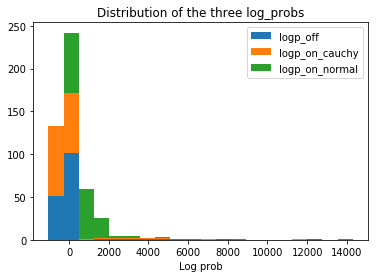

In [42]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the three log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

In [ ]:
list_of_movie_files = []
for epoch in range(0,125,5):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
        print(label,vae.p_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
        counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass
    
print(list_of_movie_files)

In [ ]:
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)


## Check individual images

In [ ]:
#from ipywidgets import interactive, IntSlider
#from PIL import Image
from IPython.display import Image

def show_frame(n):
    return Image(filename=write_dir+list_of_movie_files[n])  
    #image = Image.open(write_dir+list_of_movie_files[n], mode='r')
    #plt.imshow(image)
    #plt.show()    

# Widget does not work
#interactive_plot = interactive(show_frame,n=IntSlider(min=0, max=N_frames-1, step=1))
#output = interactive_plot.children[-1]
#interactive_plot

In [ ]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#name_vae = "MNIST_unit_cauchy_t4_v2_vae_0"
#list_of_movie_files = []
#for file in os.listdir(write_dir):
#    if file.startswith(name_vae) and file.endswith(".png"):
#        list_of_movie_files.append(file)
N_frames = len(list_of_movie_files)
print(list_of_movie_files)
print(N_frames)

In [ ]:
show_frame(0)

In [ ]:
show_frame(9)

In [ ]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")